# T0 - Add DOTNAME field
In this tutorial we show how to add a new field, "DOTNAME", to a shapefile. RasterTools often uses this field as part of the book-keeping.

In [ ]:
import zipfile
import rastertools
from pathlib import Path
from shapefile import Reader, Writer
from rastertools.shape import plot_shapes, long_mult
from zenodo_client import Zenodo
print(f"rastertools version v{rastertools.__version__}")

We will use Zenodo to download some shapefiles created for the report "A Climate Resilient Path for Ireland’s Marine Protected Areas Network". From [the documentation](https://zenodo.org/records/10790050):

> These shapefiles summarise long-term patterns that emerge from the spatial-meta analysis of physical-biogeochemical and species distribution modelling data, providing an overview of the distribution of climate change refugia and climate change hotspots across Ireland's National Marine Planning Framework between 2026 - 2069, and across the two emissions scenarios considered in the report (RCP4.5 and RCP8.5).

In [2]:
# downlod and extract from zenodo
# https://zenodo.org/records/10790050
new_record = Zenodo().download_latest(10790050, 'FairSeas_refugia_hotspots_shapefiles_2024.zip')
with zipfile.ZipFile(new_record, 'r') as zip_ref:
    zip_ref.extractall(Path('./results') / new_record.stem)

Here is some information about the shapefile and its associated metadata:

In [3]:
# original shapefile
shape_file = Path('./results/FairSeas_refugia_hotspots_shapefiles_2024/FairSeas_pelagic_habitats_hotspots_80/FairSeas_pelagic_habitats_hotspots_80_new.shp')
sf = Reader(shape_file)

# number of records
num_records = len(sf.records())

# print the field names for the records
print(f"Number of records: {num_records}")
print("Fields in the original shapefile:")
print([field[0] for field in sf.fields[1:]])
print("For examples, the first record:")
print(sf.record(0).as_dict())

Number of records: 1
Fields in the original shapefile:
['lyr_1']
For examples, the first record:
{'lyr_1': -1}


But when we try to plot it using RasterTools `plot_shapes` function we get an error:

Error: DOTNAME is not a field name


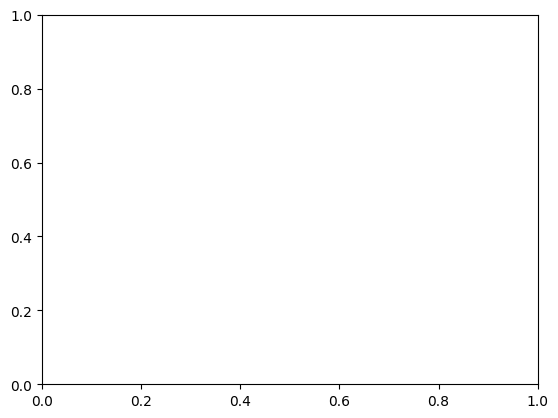

In [4]:
try:
    fig, ax = plot_shapes(shape_file)
except Exception as e:
    print(f"Error: {e}")

Here is an example of how to create a new shapefile with a DOTNAME field. Often you might want to combine meta data, for example if you had a shapefile of US counties you could create a "COUNTY.STATE" DOTNAME. In this example we only have one field so we'll just use that.

In [5]:
def add_dotname(shapefile, dotname_fields=['lyr_1']):

    new_shape_file = shapefile.parent / (shapefile.stem + '_DN.shp')

    # shapefiles
    sf = Reader(shapefile)
    w = Writer(target=new_shape_file)

    # add the original fields
    for i, field in enumerate(sf.fields):
        if i > 0:
            w.field(*field)
    # add the new field
    w.field('DOTNAME', 'C', 50)

    for i, shaperec in enumerate(sf.iterShapeRecords()):
        # add the new field
        w.record(*shaperec.record, '.'.join([str(shaperec.record[field]).lower() for field in dotname_fields]))
        # add the shape
        w.shape(shaperec.shape)
    w.close()
    sf.close()

    return new_shape_file

new_shape_file = add_dotname(shape_file, dotname_fields=['lyr_1'])

and now we can plot:

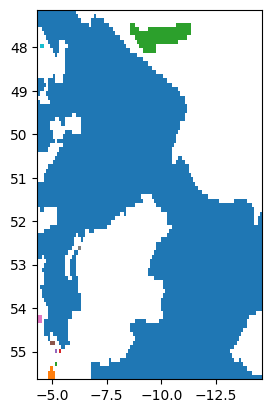

In [6]:
fig, ax = plot_shapes(new_shape_file)
ax.set_box_aspect(long_mult(0.5*(sf.bbox[1] + sf.bbox[3])))